In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from gensim.models import KeyedVectors
import matplotlib
import matplotlib.pyplot as plt

from models import WordEncoder, SentEncoder
from dataset import document_to_hierarchical_feature
from config import (
    BATCH_SIZE,
    DEVICE,
    WORD_HIDDEN_SIZE,
    SENT_HIDDEN_SIZE,
    BIDIRECTIONAL,
    Yelp,
    Yahoo,
    Amazon,
    Synthetic,
)

%matplotlib inline
matplotlib.rcParams["figure.figsize"] = [20, 20]

In [2]:
class Attention(nn.Module):
    def __init__(self, input_size):
        super(Attention, self).__init__()
        self.input_size = input_size
        self.fc = nn.Linear(self.input_size, self.input_size)
        self.context_vector = nn.Parameter(torch.randn(self.input_size))
        self.last_weights = []  # for attention visualization

    def forward(self, input):
        output = torch.tanh(self.fc(input))
        output = torch.matmul(output, self.context_vector)
        output = F.softmax(output, dim=1)
        output = output.permute(1, 0)
        input = input.permute(1, 0, 2)
        batch_size = input.shape[1]
        weighted_sum = torch.zeros(batch_size, self.input_size).to(DEVICE)
        self.last_weights.append([])
        for alpha, h in zip(output, input):
            self.last_weights[-1].append(alpha.item())
            alpha = alpha.unsqueeze(1).expand_as(h)
            weighted_sum += alpha * h
        return weighted_sum


class Han(nn.Module):
    "Hierachical Attention Network"

    def __init__(
        self,
        embedding_matrix,
        word_hidden_size,
        sent_hidden_size,
        num_classes,
        batch_size,
    ):
        super(Han, self).__init__()
        self.word_hidden_size = word_hidden_size
        self.word_encoder = WordEncoder(embedding_matrix, word_hidden_size)
        self.word_attention = Attention(word_hidden_size * BIDIRECTIONAL)
        self.sent_hidden_size = sent_hidden_size
        self.sent_encoder = SentEncoder(
            word_hidden_size * BIDIRECTIONAL, sent_hidden_size
        )
        self.sent_attention = Attention(sent_hidden_size * BIDIRECTIONAL)
        self.fc = nn.Linear(sent_hidden_size * BIDIRECTIONAL, num_classes)
        self.init_hidden_state(batch_size)

    def init_hidden_state(self, batch_size):
        self.word_hidden_state = torch.zeros(
            BIDIRECTIONAL, batch_size, self.word_hidden_size
        ).to(DEVICE)
        self.sent_hidden_state = torch.zeros(
            BIDIRECTIONAL, batch_size, self.sent_hidden_size
        ).to(DEVICE)

    def forward(self, input):
        input = input.permute(1, 2, 0)
        self.sent_hidden_state = torch.zeros_like(self.sent_hidden_state).to(DEVICE)
        sent_encoder_outputs = []
        self.word_attention.last_weights = []
        self.sent_attention.last_weights = []
        for sentence in input:
            self.word_hidden_state = torch.zeros_like(self.word_hidden_state).to(DEVICE)
            word_encoder_outputs = []
            for word in sentence:
                word = word.unsqueeze(0)
                output, self.word_hidden_state = self.word_encoder(
                    word, self.word_hidden_state
                )
                word_encoder_outputs.append(output)
            word_attn_input = torch.cat(word_encoder_outputs, dim=0)
            word_attn_input = word_attn_input.permute(1, 0, 2)
            output = self.word_attention(word_attn_input)
            output = output.unsqueeze(0)
            output, self.sent_hidden_state = self.sent_encoder(
                output, self.sent_hidden_state
            )
            sent_encoder_outputs.append(output)
        sent_attn_input = torch.cat(sent_encoder_outputs, dim=0)
        sent_attn_input = sent_attn_input.permute(1, 0, 2)
        output = self.sent_attention(sent_attn_input)
        output = self.fc(output)
        output = F.log_softmax(output, dim=1)
        return output

In [251]:
dataset_config = Synthetic

wv = KeyedVectors.load(dataset_config.EMBEDDING_FILE)

df = pd.read_csv(dataset_config.TEST_DATASET).fillna("")

model = Han(
    embedding_matrix=wv.vectors,
    word_hidden_size=WORD_HIDDEN_SIZE,
    sent_hidden_size=SENT_HIDDEN_SIZE,
    num_classes=len(df.label.unique()),
    batch_size=1,
).to(DEVICE)
model.load_state_dict(
    torch.load(
        "models/synthetic-han-80pad.pth", map_location=torch.device(DEVICE)
    )
)

<All keys matched successfully>

In [252]:
index = (
    df[(df["label"] == 0) & (df["text"].str.len() > 50) & (df["text"].str.len() < 200)]
    .sample(1)
    .index.tolist()[0]
)
label, doc = df.loc[index]

f = document_to_hierarchical_feature(doc, wv)
sent_per_doc = len(f)
words_per_sent = len(max(f, key=len))
#sent_per_doc = dataset_config.SENT_PER_DOC[80]
#words_per_sent = dataset_config.WORDS_PER_SENT[80]
features = np.zeros(shape=(1, sent_per_doc, words_per_sent), dtype=np.int64)
for i, sentence in zip(range(sent_per_doc), f):
    for j, word in zip(range(words_per_sent), sentence):
        features[0, i, j] = word

prediction = model(torch.LongTensor(features).to(DEVICE)).argmax(1).item()
print(f"{index = }")
print(f"{label = }")
print(f"{prediction = }")
print(doc)

index = 24039
label = 0
prediction = 0
Any element of a tuple can be accessed in constant time. Ports are used to communicate with the external world. I do n't worst even care .


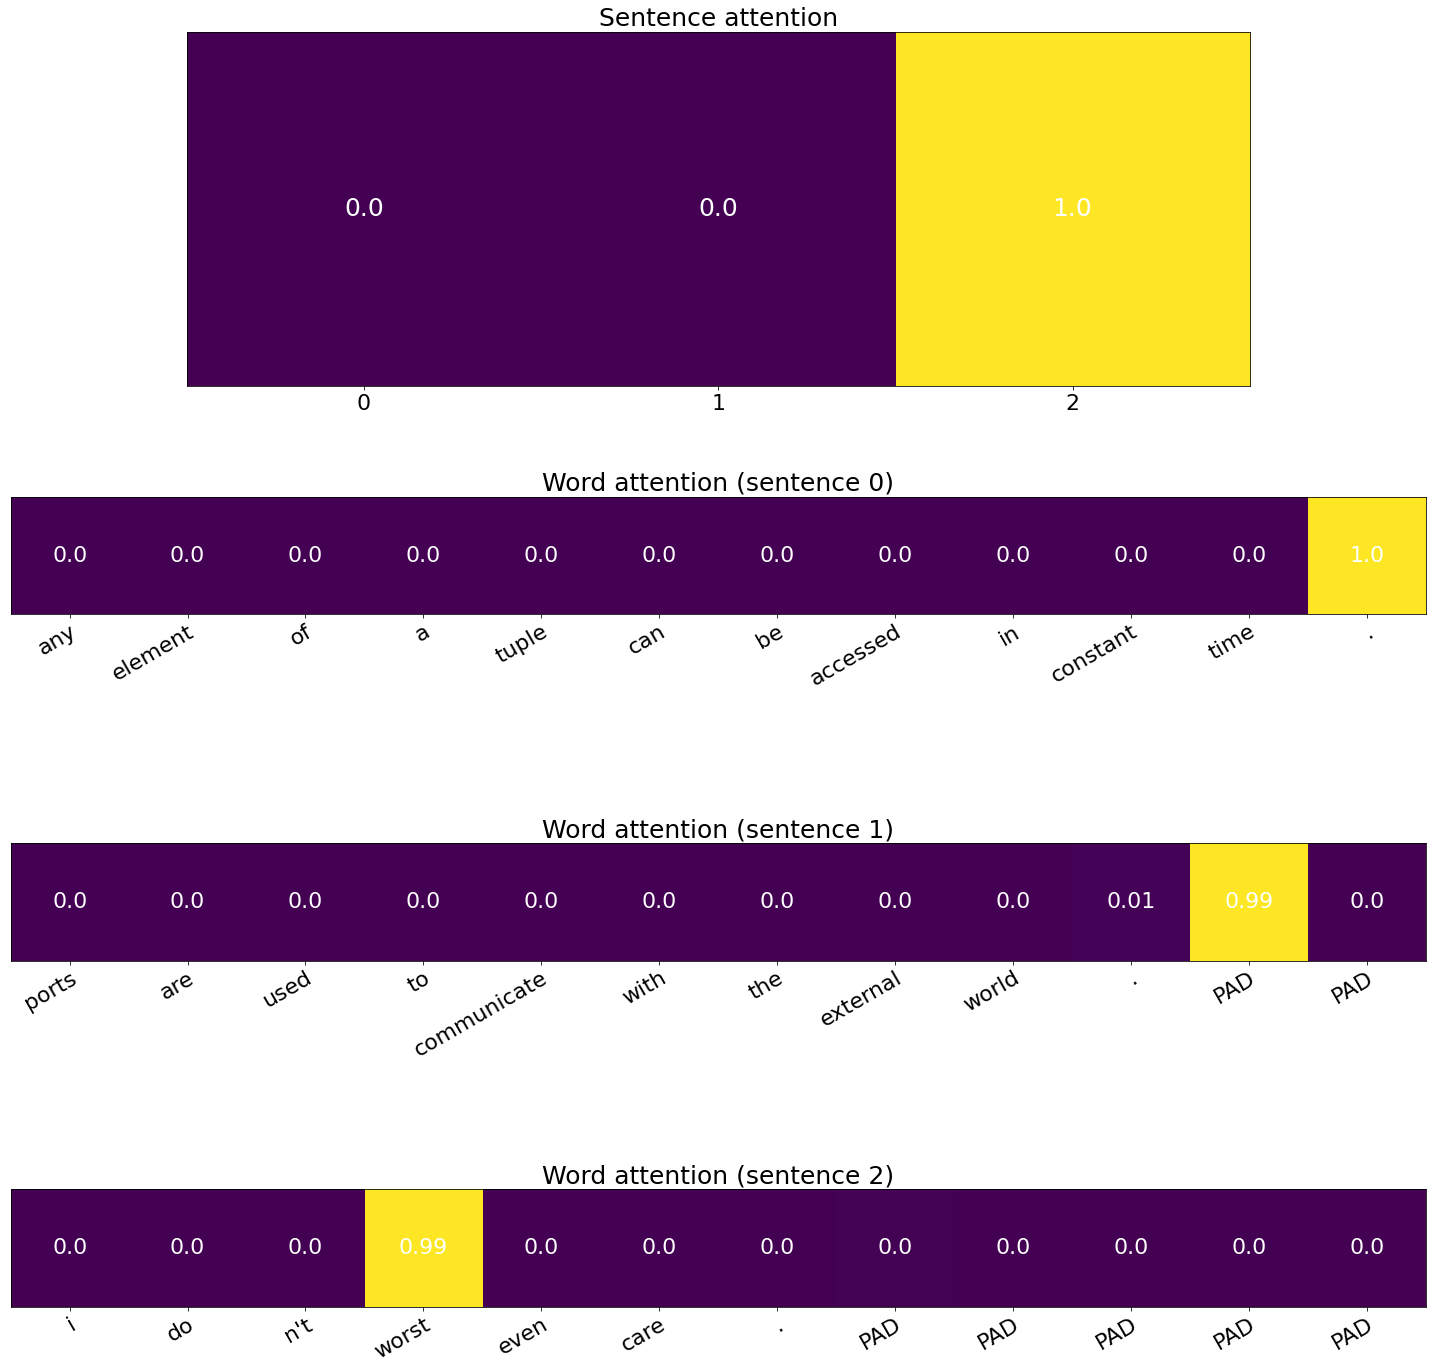

In [253]:
fig, axs = plt.subplots(nrows=(len(features[0]) + 1), ncols=1)
im = axs[0].imshow([model.sent_attention.last_weights[0]])
axs[0].set_xticks(range(sent_per_doc))
axs[0].set_xticklabels(range(sent_per_doc), fontsize=22)
axs[0].set_title("Sentence attention", fontsize=25)

# Rotate the tick labels and set their alignment.
# plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

# Add attention weight in each rectangle
for j in range(sent_per_doc):
    axs[0].text(
        j,
        0,
        round(model.sent_attention.last_weights[0][j], 2),
        fontsize=25,
        ha="center",
        va="center",
        color="w",
    )

# Remove y ticks
axs[0].yaxis.set_major_locator(plt.NullLocator())

for ax, (i, sentence) in zip(axs[1:], enumerate(features[0])):
    im = ax.imshow([model.word_attention.last_weights[i]])
    ax.set_xticks(range(len(sentence)))
    ax.set_xticklabels((wv.index2word[f] for f in sentence), fontsize=22)
    ax.set_title(f"Word attention (sentence {i})", fontsize=25)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # Add attention weight in each rectangle
    for j in range(len(sentence)):
        ax.text(
            j,
            0,
            round(model.word_attention.last_weights[i][j], 2),
            fontsize=22,
            ha="center",
            va="center",
            color="w",
        )

    # Remove y ticks
    ax.yaxis.set_major_locator(plt.NullLocator())
    
fig.tight_layout()
fig.savefig("slides/img/synthetic-han-visual.pdf")